## Instruções
- Redes Neuronais + Backpropagation

Neste trabalho você irá implementar uma rede neuronal com três camadas:

1. Camada de entrada: cada unidade representa uma dimensão do dado de entrada.

2. Camada oculta: cada unidade representa uma transformação a partir das unidades de entrada.

3. Camada de saída: cada unidade representa a chance da saída correspondente ser a correta.

Você irá utilizar a função Sigmóide para obter não-linearidade. Além disso, a função de perda a ser minimizada é a seguinte:

![title](formula.jpg)

onde m é a quantidade de entradas no treino, K é o número de saídas possíveis,  representa a saída correta de cada classe k em cada entrada (i), e similarmente representa a saída dada pela rede neuronal.

O dado a ser utilizado está anexado. Trata-se de 5000 entradas, onde cada entrada refere-se a um dígito escrito manualmente (i.e., MNIST dataset). Dessa forma, m=5000 e K=10. Cada entrada é dada por uma matriz de dimensões 28 por 28, ou seja, um vetor de 784 dimensões. A primeira coluna do arquivo sempre é o rótulo do dígito correto.

A rede neuronal a ser implementada deverá ter 784 unidades de entrada e 10 unidades de saída. Em seus experimentos, você deverá variar o número de unidades na camada oculta (25, 50, 100).

Além disso, você deverá comparar os seguintes algoritmos de cálculo de gradiente:

1. Gradient Descent: o gradiente é calculado após cada época (após as 5000 entradas serem processadas).

2. Stochastic Gradient Descent: o gradiente é calculado após cada entrada.

3. Mini-Batch: o gradiente é calculado após um certo número de entradas (considere 10 e 50).

Por fim, você também deverá variar a taxa de aprendizado: 0.5, 1, 10.

O documento a ser entregue deverá apresentar o resultado de seus experimentos. Ou seja, deverá apresentar discussão da variação do número de unidades na camada oculta para cada um dos três algoritmos de cálculo de gradiente. Você deverá apresentar gráficos mostrando a convergência do erro empírico para cada situação (unidades na camada oculta, algoritmo de cálculo do gradiente, taxa de aprendizado). Você deverá deixar claras todas as hipóteses que julgar serem pertinentes.

# Resolução

Para esse trabalho prático utilizarei a biblioteca KERAS para criar o modelo de rede neuronal proposto. Além disso, usaremos a biblioteca numpy e pandas para tratar dados vetoriais e para plotar gráficos dos resultados obtidos.

Os comentários e conclusões estão presentes juntamente com o código desse notebook.

In [1]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras import optimizers
import numpy
import keras

# fix random seed for reproducibility
numpy.random.seed(7)

/home/lfmendes/data/mestrado/machine-learning/venv/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Carregando Arquivo
Carregando o arquivo com os 5000 digitos e dividindo em X (matrix com as features) e y (vetor com as respostas)

Além disso, definimos o número de categorias(classes) baseados no y e o número de pixels

In [18]:
# load pima indians dataset
dataset = numpy.loadtxt("/home/lfmendes/data/mestrado/machine-learning/ml-neural/data_tp1.csv", delimiter=",")

# split into input (X) and output (Y) variables
X = dataset[:,1:]
y = dataset[:,0]

y_cat = np_utils.to_categorical(y)
num_classes = y_cat.shape[1]

num_pixels = 784

print("Número de entradas: %s" % (len(y)))
print("Número de features: %s" % (len(X[0])))
print("Número de classes: %s" % (num_classes))

Número de entradas: 5000
Número de features: 784
Número de classes: 10


## Código para criação do modelo dado os parâmetros que podem ser variados

A função a seguir irá definir o modelo que será utilizado, dando espaço para modificar os parâmetros pedidos, no caso definimos os seguintes parâmetros:

* learning_rate - Taxa de aprendizado
* neuronios_ocultos - Quantidade de neuronios na camada oculta

O modelo a ser cosntruído é composto de
* uma camada de entrada com 784 neuronios e utiliza a função de ativação 'sigmoid'.
* uma camada oculta com o número de neurônios parametrizada pela função
* uma camada de saída com número de neurônios igual ao número de classes, nesse caso utilizamos a função softmax 

Para fazer a otimização do modelo, estamos usando um SGD com learning rate definido no parâmetro da função. Importante salientar que durante o **fit** se utilizarmos o SGD com batch size igual a 1 ele se comporta como Stochastic Gradient Descent (o gradiente é calculado após cada entrada), se usarmos o batch size igual ou maior ao tamanho do treino ele se comporta como Gradient Descent (o gradiente é calculado após cada época) e nos outros casos ele funciona como Mini-Batch: o gradiente é calculado após um certo número de entradas.

A função de perda utilizada é a **categorical_crossentropy** e a métrica utilizada é a **acurácia**.

![alt text](rede.png "Desenho da Rede")

In [4]:
def create_model(learning_rate=0.5,neuronios_ocultos=25):
    # create model   
    model = Sequential()
    model.add(Dense(num_pixels, activation='sigmoid', input_shape=(784,)))
    model.add(Dense(neuronios_ocultos, activation='sigmoid'))
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile model
    sgd = optimizers.SGD(lr=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])    
   
    return model

## Fazendo experimentação
Dividindo em treino e teste usando 5 kfolds.

Na próxima célula definimos uma função que separa em folds, sendo que para isso ela aleatoriza a entrada e utiliza uma semente aleatória. Além disso, por estarmos utilizando a função **StratifiedKFold** da biblioteca **sklearn** então os folds irão ser criados de forma a respeitar a dsitribuição de classes da entrada

Já a função **experimentation()** é a principal desse trabalho, nela fazemos 
* a divisão de folds da entrada
* o tratamento da entrada, passando os valores brutos para floats 
* transformamos nossa entrada em vetorial ou categórica, isto é, um valor como 2 vira [0,1,0,0,0,0,0,0,0,0]
* Criamos o modelo como já definido na função **create_model()**
* Fazemos o fit desse modelo utilizando apenas os dados de treino
* Calculamos e guardamos a acurácia obtida nos dados de teste

In [5]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

fold_size = 5

def get_folds(seed,fold_size=5):    
    return StratifiedKFold(n_splits=fold_size, random_state=seed,shuffle=True)

def experimentation(batch_size=5000,learning_rate=0.5,neuronio=100,epochs=250,seed=42, verbose=0):    
    fold = 0
    avg_error = 0.0
    avg_acc = 0.0
    first = True
    accs = []
    
    skf = get_folds(seed)
    
    for train_index, test_index in skf.split(X, y):        
        if(verbose > 0):          
            print("Fazendo teste nos fold " + str(fold))
            print("batch_size: " + str(batch_size))
            print("learning_rate: " + str(learning_rate))
            print("neuronio: " + str(neuronio))
            print("epochs: " + str(epochs))

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        X_train = X_train.reshape(len(train_index), 784)
        X_test = X_test.reshape(len(test_index), 784)
        X_train = X_train.astype('float32')
        X_test = X_test.astype('float32')
        X_train /= 255
        X_test /= 255
        
        if(verbose > 0):
            print(X_train.shape[0], 'train samples')
            print(X_test.shape[0], 'test samples')

        y_train = np_utils.to_categorical(y_train)
        y_test = np_utils.to_categorical(y_test)   
        
        if(verbose > 0):
            print('Distribuicao no treino: ' + str(y_train.sum(axis=0, dtype='float')))
            print('Distribuicao no test: ' + str(y_test.sum(axis=0, dtype='float')))

        model=create_model(learning_rate=learning_rate,neuronios_ocultos=neuronio)
        
        if((verbose > 0) and first):
            model.summary()
            first = False

        # Fit the model
        model.fit(X_train, y_train, validation_data=(X_test, y_test),
                  epochs=epochs, batch_size=batch_size, verbose=verbose,
                  shuffle=True)

        # Final evaluation of the model        
        if(verbose > 0):
            # Avaliando no Treino (verificar caso de overfitting)
            scores = model.evaluate(X_train, y_train, verbose=1)
            print("Resultado no Treino")
            print("Baseline Error: %.2f%%" % (100-scores[1]*100))
            print("%s: %.2f%%\n" % (model.metrics_names[1], scores[1]*100))
        
        # Avaliando o Teste
        scores = model.evaluate(X_test, y_test, verbose=verbose)        
        if(verbose > 0):
            print("Resultado no Teste")
            print('Distribuicao na predicao: ' + str(model.predict(X_test).sum(axis=0, dtype='float')))
            print("Baseline Error: %.2f%%" % (100-scores[1]*100))
            print("%s: %.2f%%\n\n" % (model.metrics_names[1], scores[1]*100))
        
        avg_acc = avg_acc + scores[1]*100
        accs.append(scores[1]*100) 

        fold=fold+1

    print('Acurácia média:' + str(avg_acc/fold_size))
    if(verbose > 0):
        print(accs)
    print('\n   ---------------------  \n')
    return accs

## Definindo parâmetros de teste

Para realizar os testes requisitados no trabalho, vamos definir alguams variáveis contendo os valores possíveis para cada parâmetro.

* batch size - Variando entre um SGD puro e o Gradient Descent
* learning rate - Variando as taxas de aprendizado
* neuronios - Variando a quantidade de neurônios na camada oculta
* epochs - Variando a quantidade de épocas 

Além disso, definimos 5 sementes para serem utilizadas durante a experimentação, sendo assim para cada valor de parâmetro teremos 25 resultados sendo 5 de cada fold para cada semente. Isto foi feito para aproximarmos melhor dos valores reais.

In [6]:
batch_sizes=[1,10,50,5000]
learning_rates=[0.5, 1, 10]
neuronios=[25,50,100]
epochs_variations=[20,100,250,500]

# Seeds utilizadas para rodar vários experimentos e termos um valor mais aproximado do "real"
iterations=[120,1111,422,122,8999]

## Visualizando o resultado

Para facilitar as conclusões vamos definir uma função que mostra o histograma com as médias para cada parâmetro e o boxplot com esses valores

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (12,6)

def print_results(results):
    df = pd.DataFrame(results)
    print(df)
    print('Média por coluna')
    print(df.mean())
    plt.bar(list(df.mean().keys()), df.mean(), color='g')
    plt.show()
    df.boxplot()

## Experimentando com batch size

O objetivo desses experimentos é verificar qual o impacto do batch_size no resultado. 

Nesse caso estamos realizando os seguintes experimentos

1. Gradient Descent: o gradiente é calculado após cada época (após as 5000 entradas serem processadas).

2. Stochastic Gradient Descent: o gradiente é calculado após cada entrada.

3. Mini-Batch: o gradiente é calculado após um certo número de entradas (considere 10 e 50).

In [9]:
batches_results = {}
for batch in batch_sizes:
    print('Experimentando com batch size igual a ' + str(batch))
    print('\n')
    batches_results[str(batch)] = []
    #for it in iterations: 
    batches_results[str(batch)].extend(experimentation(batch_size=batch))
    print(batches_results)     

Experimentando com batch size igual a 1


Acurácia média:9.640149848973985

   ---------------------  

{'1': [9.172482552342972, 9.990009990009991, 9.809809814284632, 10.010010014484832, 9.218436873747494]}
Experimentando com batch size igual a 10


Acurácia média:93.35925914740874

   ---------------------  

{'1': [9.172482552342972, 9.990009990009991, 9.809809814284632, 10.010010014484832, 9.218436873747494], '10': [93.81854439661248, 94.00599400599401, 93.1931931931932, 92.99299299895942, 92.78557114228457]}
Experimentando com batch size igual a 50


Acurácia média:92.23961563254606

   ---------------------  

{'50': [92.62213362891558, 92.3076923076923, 92.1921921921922, 92.09209209805852, 91.98396793587175], '1': [9.172482552342972, 9.990009990009991, 9.809809814284632, 10.010010014484832, 9.218436873747494], '10': [93.81854439661248, 94.00599400599401, 93.1931931931932, 92.99299299895942, 92.78557114228457]}
Experimentando com batch size igual a 5000


Acurácia média:84.738693

Agora para visualizar melhor os resultados vamos plotar um histograma com as médias de cada valor e depois um boxplot para termos uma noção da variação do resultado

           1         10         50       5000
0   9.172483  93.818544  92.622134  86.640080
1   9.990010  94.005994  92.307692  83.416583
2   9.809810  93.193193  92.192192  85.285285
3  10.010010  92.992993  92.092092  85.185185
4   9.218437  92.785571  91.983968  83.166333
Média por coluna
1        9.640150
10      93.359259
50      92.239616
5000    84.738693
dtype: float64


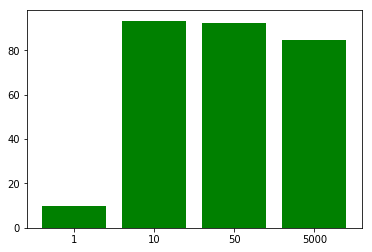

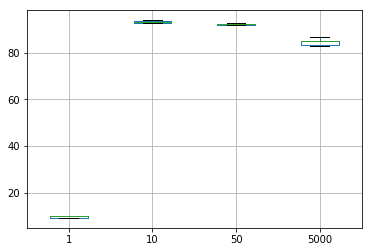

In [10]:
print_results(batches_results)

## Resultados do experimento com batch size

É fácil notar pelo gráfico que batch size que o SGD calculando a cada entrada não tornou possível convergir para uma solução, isto é, o modelo não conseguiu aprender a diferenciar os dígitos e acabou marcando apenas 1 resposta independente da entrada.

Já com batch-size de 10,50 ou de 5000 (passando por todas entradas) conseguiram convergir na maioria das vezes. 

## Experimentando com learning_rates

O objetivo desses experimentos é avaliar qual o impacto da taxa de aprendizado.
Nesse caso vamos testar as seguintes taxas de aprendizado: [0.5, 1, 10]

In [7]:
learning_rates_results = {}
for learning_rate in learning_rates:
    print('Experimentando com learning rate igual a ' + str(learning_rate))
    print('\n\n')
    learning_rates_results[str(learning_rate)] = []
    for it in iterations: 
        learning_rates_results[str(learning_rate)].extend(experimentation(learning_rate=learning_rate, seed=it))
    print(learning_rates_results)     

Experimentando com learning rate igual a 0.5



Acurácia média:84.5222089343894

   ---------------------  

Acurácia média:85.14101171976003

   ---------------------  

Acurácia média:84.98039221688569

   ---------------------  

Acurácia média:84.72228885411074

   ---------------------  

Acurácia média:84.44055098722936

   ---------------------  

{'0.5': [82.45264206783602, 84.61538462729364, 85.58558559155202, 82.48248248546571, 87.4749498997996, 85.04486540378863, 82.31768232959134, 89.08908909505551, 85.08508509701794, 84.16833667334669, 85.044865397846, 84.01598403384754, 85.68568568568568, 84.88488488488488, 85.27054108216433, 82.35294117052796, 85.01498502093952, 84.28428430218358, 84.68468469065111, 87.27454908625157, 83.74875372689837, 86.01398603184954, 82.38238238834882, 82.48248248844891, 87.5751503006012]}
Experimentando com learning rate igual a 1



Acurácia média:86.08149504004433

   ---------------------  

Acurácia média:86.77997758844946

   -----------------

          0.5          1         10
0   82.452642  85.144566   9.272183
1   84.615385  85.114885  10.289710
2   85.585586  86.886887   9.209209
3   82.482482  85.385385  10.610611
4   87.474950  87.875752  10.020040
5   85.044865  87.238285   9.970090
6   82.317682  85.214785   9.290709
7   89.089089  89.889890  10.210210
8   85.085085  86.186186   9.809810
9   84.168337  85.370741   9.719439
10  85.044865  87.238285  10.269192
11  84.015984  84.215784   9.090909
12  85.685686  88.188188   9.209209
13  84.884885  85.285285  10.210210
14  85.270541  86.773547  10.420842
15  82.352941  84.945165   9.172483
16  85.014985  86.613387   9.790210
17  84.284284  85.785786   9.209209
18  84.684685  86.786787   9.109109
19  87.274549  87.274549   9.218437
20  83.748754  84.745763   9.770688
21  86.013986  87.812188   9.790210
22  82.382382  87.387387   9.209209
23  82.482482  86.086086   9.109109
24  87.575150  87.174349  10.220441
Média por coluna
0.5    84.761291
1      86.424796
10      9.688

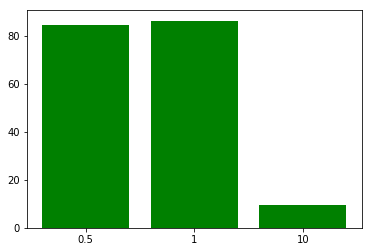

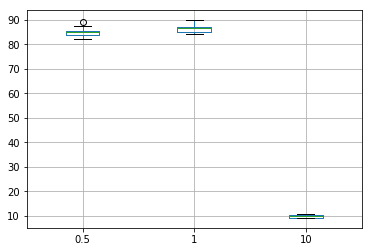

In [8]:
print_results(learning_rates_results)

## Resultados do experimento com learning rate

Os dois gráficos utilizados mostram claramente que o learning rate de 10 não produz bons resultados, sendo que o modelo não consegue aprender e está claramente underfitado.

Tanto o learning rate de 0.5 quanto 1 chegam em valores próximos de 84-86% de acurácia.

## Experimentando com neuronios na camada oculta

O objetivo desses experimentos é avaliar qual o impacto do número de neurônios na camada oculta.

In [9]:
neuronios_results = {}
for neuronio in neuronios:
    print('Experimentando com learning rate igual a ' + str(neuronio))
    print('\n\n')
    neuronios_results[str(neuronio)] = []
    for it in iterations: 
        neuronios_results[str(neuronio)].extend(experimentation(neuronio=neuronio,seed=it))
    print(neuronios_results)     

Experimentando com learning rate igual a 25



Acurácia média:83.46056621080481

   ---------------------  

Acurácia média:83.38264386149709

   ---------------------  

Acurácia média:83.56028676821556

   ---------------------  

Acurácia média:84.56081108423197

   ---------------------  

Acurácia média:84.24018831302871

   ---------------------  

{'25': [82.65204386245217, 84.01598402789303, 84.68468469065111, 81.78178179968107, 84.16833667334669, 81.15653040283104, 81.71828173019074, 86.18618619215262, 83.48348349541635, 84.36873748689472, 83.3499501733219, 83.01698302889203, 84.58458458458459, 83.78378378975022, 83.06613226452906, 84.44666001399754, 83.31668334050136, 84.38438440228367, 84.98498499095142, 85.67134267342593, 83.25024927007118, 86.01398603184954, 83.78378379571664, 83.38338338934982, 84.76953907815631]}
Experimentando com learning rate igual a 50



Acurácia média:84.94061205034349

   ---------------------  

Acurácia média:85.28097403769982

   --------------

          100         25         50
0   83.250249  82.652044  84.546361
1   84.815185  84.015984  84.915085
2   85.785786  84.684685  86.486486
3   83.783784  81.781782  82.382382
4   86.673347  84.168337  86.372745
5   83.449651  81.156530  85.842473
6   83.616384  81.718282  81.918082
7   87.987988  86.186186  88.588589
8   85.285285  83.483483  84.384384
9   84.068136  84.368737  85.671343
10  85.343968  83.349950  86.141575
11  83.716284  83.016983  82.917083
12  84.684685  84.584585  85.785786
13  84.684685  83.783784  84.584585
14  85.470942  83.066132  85.170341
15  83.250249  84.446660  84.945165
16  85.514486  83.316683  85.714286
17  84.784785  84.384384  84.284284
18  85.485485  84.984985  86.486486
19  86.973948  85.671343  86.673347
20  84.047856  83.250249  84.446660
21  86.513487  86.013986  86.813187
22  85.785786  83.783784  86.286286
23  84.284284  83.383383  84.784785
24  86.472946  84.769539  85.871743
Média por coluna
100    85.029187
25     83.840899
50     85.280

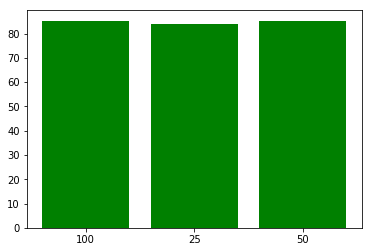

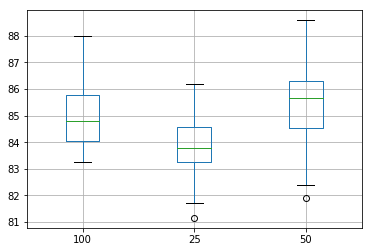

In [10]:
print_results(neuronios_results)

## Resultados do experimento com neuronios na camada oculta

O experimento com neurônios na camada oculta mostra que a variação entre 25-50-100 não muda muito a mediana, ficando em valores próximos a 85.

A média de 50 e 100 ficaram em torno de 85 e a variação de 100 ficou acima das outras duas opções. Mostrando que como esperado a acurácia tende a aumentar com aumento do número de neurônios.

Devemos nos lembrar no entanto que isso pode levar ao overfitting. Nesse caso, estamos trabalhando com erro de teste justamente para tirar uma conclusão errada nesse sentido.



## Variando o número de camadas ocultas para cada gradiente

In [11]:
import itertools

neuroniosXbatch_results = {}
for x in itertools.product(batch_sizes, neuronios):    
    neuronio = x[1]
    batch = x[0]
    print('Experimentando com  (batch,neuronio)' + str(x))
    print('\n\n')
    neuroniosXbatch_results[str(x)] = []    
    neuroniosXbatch_results[str(x)].extend(experimentation(neuronio=neuronio,batch_size=batch))
    print(neuroniosXbatch_results)    

print_results(neuroniosXbatch_results)

# Mostrando resultado da acurácia durante as epochs

In [19]:
X = X.astype('float32')
X /= 255

y = np_utils.to_categorical(y)

In [20]:
model=create_model(learning_rate=0.5,neuronios_ocultos=50)

# Fit the model
history = model.fit(X, y, validation_split=0.33, epochs=500, batch_size=500, verbose=0)

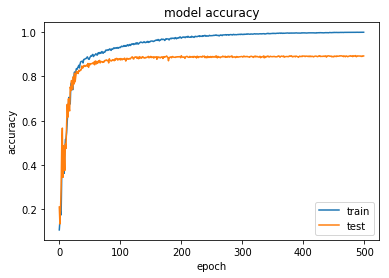

In [21]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

In [22]:
history.history['val_acc'][-1]

0.8927922473395686

É possível perceber que com umas 300 epochs o modelo já aprende completamente o treino e com menos de 100 ele já chega no "valor final de acurácia" no teste. Tendo uma pequena variação em torno da acurácia final (0.89)

Agora vamos realizar o teste com um learning rate maior


In [23]:
model=create_model(learning_rate=1.0,neuronios_ocultos=50)

# Fit the model
history = model.fit(X, y, validation_split=0.33, epochs=500, batch_size=500, verbose=0)

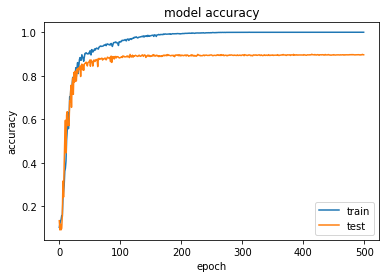

In [24]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

In [25]:
history.history['val_acc'][-1]

0.8964264294654943

Com esse learning rate mais alto, podemos perceber que existe uma variação maior durante as epochs, principalmente nas 100 primeiras. 
Mas o resultado final tende para o mesmo, que é um modelo que decorou o treino e com um resultado proximo de 0.89 no teste.